In [7]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization
from keras import optimizers
from keras import metrics
from keras import models
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow
import functools
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report, fbeta_score
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import common

print(tensorflow.config.list_physical_devices('GPU'))
print(tensorflow.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [11]:
train = common.load_train_dataset('dataset/multilabel.csv')

print('Number of train samples: ', train.shape[0])
train["attribute_ids"] = train["attribute_ids"].apply(lambda x: x.split(" "))
display(train.head())

test = common.load_train_dataset('dataset/multilabel.csv')

print('Number of test samples: ', test.shape[0])
test["attribute_ids"] = test["attribute_ids"].apply(lambda x: x.split(" "))
display(test.head())

Number of train samples:  93606


,id,attribute_ids
19319,417c73812224c3d8.png,[156]
47288,890a7eb0b5fe27ff.png,[147]
4839,1c5140c3a315ed65.png,[147]
5371,1d9f5ed7230830ab.png,[188]
23730,4c8c750e935c3b2c.png,[13]


Number of test samples:  93606


,id,attribute_ids
4968,1c9f19da3e104c0c.png,[188]
84763,e9ea17bd4bd0a78.png,"[189, 378]"
12084,2f0ff4e9b0fb8057.png,[194]
78759,da69238ce7f33a45.png,[79]
3289,18364e4950c3c894.png,[147]


In [3]:
# Model parameters
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 0.0001
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = 72

In [12]:
train_generator, valid_generator, test_generator = common.create_image_generators("dataset/train", "dataset/test", train, test, BATCH_SIZE, (HEIGHT, WIDTH), data_augmentation=False)

Found 74885 validated image filenames belonging to 72 classes.
Found 18721 validated image filenames belonging to 72 classes.
Found 0 validated image filenames belonging to 0 classes.
C:\Users\Mário Mesquita\AppData\Local\Programs\Python\Python37\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 93606 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [5]:
model = models.Sequential()

model.add(Conv2D(filters=96, kernel_size=(11,11), strides=4, input_shape=(HEIGHT, WIDTH, CANAL), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))

model.add(Conv2D(filters=256, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))

model.add(Conv2D(filters=384, kernel_size=(3,3), padding='Same', activation='relu'))

model.add(Conv2D(filters=384, kernel_size=(3,3), padding='Same', activation='relu'))

model.add(Conv2D(filters=384, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(N_CLASSES, activation="sigmoid"))
model.summary()

optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 18, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 384)         8

In [6]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    verbose=1)

model.save('task2')

Epoch 1/30
4680/4680 [==============================] - 594s 124ms/step - loss: 0.3742 - accuracy: 0.0788 - val_loss: 0.0695 - val_accuracy: 0.1333
Epoch 2/30
4680/4680 [==============================] - 397s 85ms/step - loss: 0.0638 - accuracy: 0.2054 - val_loss: 0.0573 - val_accuracy: 0.2267
Epoch 3/30
4680/4680 [==============================] - 403s 86ms/step - loss: 0.0589 - accuracy: 0.2392 - val_loss: 0.0550 - val_accuracy: 0.2508
Epoch 4/30
4680/4680 [==============================] - 421s 90ms/step - loss: 0.0544 - accuracy: 0.2878 - val_loss: 0.0506 - val_accuracy: 0.3135
Epoch 5/30
4680/4680 [==============================] - 418s 89ms/step - loss: 0.0506 - accuracy: 0.3251 - val_loss: 0.0516 - val_accuracy: 0.3230
Epoch 6/30
4680/4680 [==============================] - 395s 84ms/step - loss: 0.0477 - accuracy: 0.3678 - val_loss: 0.0459 - val_accuracy: 0.3716
Epoch 7/30
4680/4680 [==============================] - 389s 83ms/step - loss: 0.0452 - accuracy: 0.3972 - val_loss: 

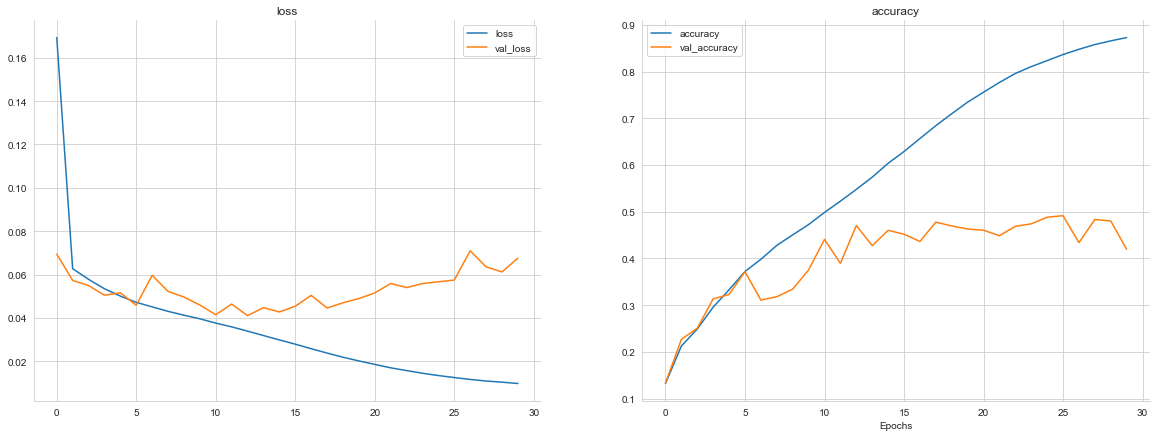

In [7]:
common.plot_history(history, ["loss", "accuracy"])

In [5]:
model = models.load_model('task2')
model.evaluate(valid_generator, verbose=1)

1171/1171 [==============================] - 96s 71ms/step - loss: 0.0290 - accuracy: 0.6853


[0.028954828158020973, 0.6853266358375549]

In [15]:
preds = model.predict(valid_generator)

thresh = 0.5
y_pred = np.array([[1 if i > thresh else 0 for i in j] for j in preds])

y_true = valid_generator.classes

print(classification_report(MultiLabelBinarizer().fit_transform(y_true), y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.03      0.01      0.02       337
           2       0.00      0.00      0.00        21
           3       0.07      0.06      0.07      1378
           4       0.00      0.00      0.00        98
           5       0.02      0.01      0.01       103
           6       0.09      0.07      0.08      1795
           7       0.01      0.01      0.01       165
           8       0.00      0.00      0.00        55
           9       0.00      0.00      0.00        68
          10       0.15      0.20      0.17      2707
          11       0.05      0.03      0.04       997
          12       0.03      0.02      0.03       417
          13       0.00      0.00      0.00        21
          14       0.00      0.00      0.00        23
          15       0.03      0.02      0.02       127
          16       0.00      0.00      0.00       128
          17       0.00    

In [31]:
print(f'Weighted: {fbeta_score(MultiLabelBinarizer().fit_transform(y_true), y_pred, beta=2, average="weighted")}')
print(f'Samples: {fbeta_score(MultiLabelBinarizer().fit_transform(y_true), y_pred, beta=2, average="samples")}')
print(f'Micro: {fbeta_score(MultiLabelBinarizer().fit_transform(y_true), y_pred, beta=2, average="micro")}')
print(f'Macro: {fbeta_score(MultiLabelBinarizer().fit_transform(y_true), y_pred, beta=2, average="macro")}')


Weighted: 0.0699732058534217
Samples: 0.07065319228131044
Micro: 0.0725298366029811
Macro: 0.014457600807621195
